In [2]:
from sklearn.metrics import adjusted_rand_score
import datetime
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from math import radians, cos, sin, asin, sqrt
from datetime import timedelta
from statistics import mode
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

In [3]:
def danslajourne(x):
    if 4 < x <= 12:
        return 'matin'
    elif 12 < x < +20:
        return 'après-midi'
    else:
        return 'nuit'
    
def saison(x):
    if x in [12, 1, 2]:
        return 'hiver'
    elif x in [3, 4, 5]:
        return 'printemps'
    elif x in [6, 7, 8]:
        return 'été'
    elif x in [9, 10, 11]:
        return 'automne'

def mois(x):
    if x in range(11):
        return 'début'
    elif x in range(11, 21):
        return 'milieu'
    elif x in range(21, 32):
        return 'fin'



def haversine_distance(lat1, lng1, lat2, lng2, degrees=True):
    r = 3956  # rayon de la Terre en miles

    if degrees:
        lat1, lng1, lat2, lng2 = map(radians, [lat1, lng1, lat2, lng2])

    # Formule Haversine
    dlng = lng2 - lng1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlng/2)**2
    d = 2 * r * asin(sqrt(a))
    return d


def freq(l):
    if len(l) == 1:
        return 0
    else:
        n = len(l)
        l.sort(reverse=True)
        l = [l[i]-l[i+1] for i in range(len(l)-1)]
        l = [abs(i.days) for i in l]
        return (sum(l)/n)

In [4]:
def Création_du_dataset(initial=False, period=2):
    
    """Nettoyage et feature engineering sur des données Olist complètes 
    pour la préparation d'une classification non supervisée (K-Means)
    """

    # Load datasets
    customers = pd.read_csv('donnee/olist_customers_dataset.csv')
    sellers = pd.read_csv('donnee/olist_sellers_dataset.csv')
    geolocation = pd.read_csv('donnee/olist_geolocation_dataset.csv')
    items = pd.read_csv('donnee/olist_order_items_dataset.csv')
    payments = pd.read_csv('donnee/olist_order_payments_dataset.csv')
    reviews = pd.read_csv('donnee/olist_order_reviews_dataset.csv')
    orders = pd.read_csv('donnee/olist_orders_dataset.csv')
    products = pd.read_csv('donnee/olist_products_dataset.csv')
    pro_cat_nam = pd.read_csv('donnee/product_category_name_translation.csv')

    geolocation.drop_duplicates(subset='geolocation_zip_code_prefix', inplace=True)
    customers.rename( columns={'customer_zip_code_prefix': 'zip_code_prefix'}, inplace=True)
    sellers.rename(columns={'seller_zip_code_prefix': 'zip_code_prefix'}, inplace=True)
    geolocation.rename(columns={'geolocation_zip_code_prefix': 'zip_code_prefix'}, inplace=True)
    geo_customer = pd.merge(customers, geolocation,how="left", on="zip_code_prefix")

      
     # Merge datasets
    del customers
    geo_seller = pd.merge(sellers, geolocation,how="left", on="zip_code_prefix")

    del sellers
    del geolocation
    payment_order = pd.merge(payments, orders, on="order_id", how="left")
    del payments
    del orders
    product_item = pd.merge(products, items, on="product_id", how="left")
    del products
    del items
    pay_order_review = pd.merge(payment_order, reviews, on="order_id", how="left")
    del payment_order
    del reviews
    review_customer = pd.merge(pay_order_review, geo_customer, on="customer_id", how="left")
    del pay_order_review
    del geo_customer
    prod_item_seller = pd.merge(product_item, geo_seller, on="seller_id", how="left")
    del product_item
    del geo_seller
    
    
    review_customer.loc[:, "order_purchase_timestamp"] = pd.to_datetime(review_customer["order_purchase_timestamp"])
    start = review_customer["order_purchase_timestamp"].min()
    if(initial == True):
        period = 12
    else:
        period = 12+period
    stop = start + pd.DateOffset(months=period)

    review_customer = review_customer[(review_customer["order_purchase_timestamp"] >= start)
                                      & (review_customer["order_purchase_timestamp"] < stop)]

    data = pd.merge(review_customer, prod_item_seller,
                    on="order_id", suffixes=("_customer", "_seller"), how='left')

    data.drop(['review_id', 'review_comment_title', 'review_comment_message',
               'review_creation_date', 'review_answer_timestamp'], axis=1, inplace=True)

    data.dropna(inplace=True)
    
    
    data = data[data["order_status"] == "delivered"]
    data.loc[:, "order_purchase_timestamp"] = pd.to_datetime(
        data["order_purchase_timestamp"])
    data.loc[:, "order_approved_at"] = pd.to_datetime(
        data["order_approved_at"])
    data.loc[:, "order_delivered_carrier_date"] = pd.to_datetime(
        data["order_delivered_carrier_date"])
    data.loc[:, "order_delivered_customer_date"] = pd.to_datetime(
        data["order_delivered_customer_date"])
    data.loc[:, "order_estimated_delivery_date"] = pd.to_datetime(
        data["order_estimated_delivery_date"])
    data.loc[:, "shipping_limit_date"] = pd.to_datetime(
        data["shipping_limit_date"])
    
    
    data.drop(["seller_state", "seller_city", "customer_city",
               "customer_state"], axis=1, inplace=True)
    data.rename(columns={"geolocation_state_seller": "seller_state", "geolocation_city_seller": "seller_city",
                         "geolocation_lng_seller": "lng_seller", "geolocation_lat_seller": "lat_seller",
                         "geolocation_lng_customer": "lng_customer", "geolocation_lat_customer": "lat_customer",
                         "geolocation_city_customer": "customer_city", "geolocation_state_customer": "customer_state"}, inplace=True)
    
   

    data['product_category'] = np.where((data['product_category_name'].str.contains("fashio|luggage")==True),
                                    'fashion_clothing_accessories',
                           np.where((data['product_category_name'].str.contains("health|beauty|perfum")==True),
                                    'health_beauty',
                           np.where((data['product_category_name'].str.contains("toy|baby|diaper")==True),
                                     'toys_baby',
                           np.where((data['product_category_name'].str.contains("book|cd|dvd|media")==True),
                                     'books_cds_media',
                           np.where((data['product_category_name'].str.contains("grocer|food|drink")==True), 
                                     'groceries_food_drink',
                           np.where((data['product_category_name'].str.contains("phon|compu|tablet|electro|consol")==True), 
                                     'technology',
                           np.where((data['product_category_name'].str.contains("home|furnitur|garden|bath|house|applianc")==True), 
                                                                                          'home_furniture',
                           np.where((data['product_category_name'].str.contains("flow|gift|stuff")==True),
                                     'flowers_gifts',
                           np.where((data['product_category_name'].str.contains("sport")==True),
                                     'sport',
                                     'other')))))))))

    
    data.drop("product_category_name", axis=1, inplace=True)

    data['order_purchase_year'] = data['order_purchase_timestamp'].dt.year
    data['order_purchase_month'] = data['order_purchase_timestamp'].dt.month
    data['order_purchase_day'] = data['order_purchase_timestamp'].dt.day
    data['order_purchase_hour'] = data['order_purchase_timestamp'].dt.hour
    data['order_purchase_day_of_week'] = data['order_purchase_timestamp'].dt.dayofweek

    data['product_volume_cm3'] = data.product_length_cm * \
        data.product_height_cm*data.product_width_cm

    data['danslajourne'] = data.apply(
        lambda x: danslajourne(x.order_purchase_hour), axis=1)

    data['saison'] = data.apply(
        lambda x: saison(x.order_purchase_month), axis=1)

    data['mois'] = data.apply(
        lambda x: mois(x.order_purchase_month), axis=1)

    data['temps_commande_livraison'] = (
        data['order_delivered_customer_date']-data['order_purchase_timestamp']).dt.days

    data['temps_commande_livraison_prevue'] = (
        data['order_estimated_delivery_date']-data['order_purchase_timestamp']).dt.days

    data['livraison_en_retard'] = data['order_delivered_customer_date'] > data['order_estimated_delivery_date']
    
    
    data.loc[:, 'pourcentage_valeur_produit_sur_prix_total'] = (
        data.price/data.payment_value)*100
    data.loc[:, 'pourcentage_valeur_port_sur_prix_total'] = (
        data.freight_value/data.payment_value)*100
    data[['payment_value', 'price', 'freight_value',
          'pourcentage_valeur_produit_sur_prix_total', 'pourcentage_valeur_port_sur_prix_total']]

    data['value'] = data[['freight_value', 'price']].sum(axis=1)
    # suppresion des lignes qui ne remplissent pas la condition de payment_value=price+freight_value
    data = data[data.value.round(3) == data.payment_value.round(3)]

    data.loc[:, 'paiement_avec_plusieurs_moyens'] = data['payment_sequential'] != 1

    data.loc[:, 'distance_seller_customer'] = [haversine_distance(x1, y1, x2, y2) for x1, y1, x2, y2 in zip(
        data.lat_seller, data.lng_seller, data.lat_customer, data.lng_customer)]
    
    grouped = data.groupby(['customer_unique_id'])
    nb_achat = grouped['order_id'].agg(
    ['count']).rename(columns={'count': 'nb_achat'})
    moyenne_montant_achat = grouped['payment_value'].agg(
    ['mean']).rename(columns={'mean': 'moyenne_montant_achat'})
    frais_de_port = grouped['pourcentage_valeur_port_sur_prix_total'].agg(
    ['mean']).rename(columns={'mean': '%_frais_de_livraison'})
    nb_categories = grouped['product_category'].apply(
    set).apply(len).rename("nb_categorie")
    #payment_type = grouped['payment_type'].apply(list).apply(
    #lambda l: mode(l)).rename('moyen_de_paiement')

    categorie = grouped['product_category'].apply(list).apply(
    lambda l: mode(l)).rename('categorie_la_plus_presente')


    distance_seller_customer = grouped['distance_seller_customer'].agg(
    ['mean']).rename(columns={'mean': 'distance_seller_customer'})

    volume_moyen_produit = grouped['product_volume_cm3'].agg(
    ['mean']).rename(columns={'mean': 'volume_moyen_produit'})
    poids_moyen_produit = grouped['product_weight_g'].agg(
    ['mean']).rename(columns={'mean': 'poids_moyen_produit'})
    nb_photos_moyen_produit = grouped['product_photos_qty'].agg(
    ['mean']).rename(columns={'mean': 'nb_photos_moyen_produit'})

    temps_commande_livraison = grouped['temps_commande_livraison'].agg(
    ['mean']).rename(columns={'mean': 'temps_commande_livraison'})
    retard = grouped['livraison_en_retard'].apply(
    sum).rename('nb_commande_en_retard')
    frequence = grouped['order_purchase_timestamp'].apply(
    list).apply(lambda l: freq(l)).rename('frequence')

    date_coupe = max(data['order_purchase_timestamp'])
    recence = grouped['order_purchase_timestamp'].apply(
    lambda x: (date_coupe - x.max()).days).rename('recence')
    client_depuis = grouped['order_purchase_timestamp'].apply(
    lambda x: (date_coupe - x.min()).days).rename('client_depuis')
        
    data_filter = pd.concat([nb_achat, moyenne_montant_achat, frais_de_port, nb_categories,
                    #payment_type,  categorie, distance_seller_customer,
                    volume_moyen_produit, poids_moyen_produit, temps_commande_livraison,
                    retard, frequence, recence, client_depuis], axis=1)
    data_filter.head()
        
    import datetime as dt
    from datetime import date
    from datetime import datetime
    my_date = date(2018,9,3)
    my_datetime = datetime(my_date.year, my_date.month, my_date.day)
    print(my_datetime)
        
    Rfm= data.groupby('customer_unique_id').agg({'order_purchase_timestamp': lambda date: (my_datetime - date.max()).days,
                                        'order_id': lambda num: len(num),
                                        'payment_value': lambda price: price.sum()})

    Rfm.columns=['recency','frequency','monetary']
    Rfm['recency'] = Rfm['recency'].astype(int)
    Rfm['frequency'] = Rfm['frequency'].astype(int)
    Rfm['monetary'] = Rfm['monetary'].astype(float)
        
        
    result = pd.concat([data_filter, Rfm], axis=1)
    
    return result

In [5]:
orders = pd.read_csv('donnee/olist_orders_dataset.csv')
orders = orders.loc[orders.order_status ==
                    "delivered", "order_purchase_timestamp"]
orders = pd.to_datetime(orders)
time_delta = int((orders.max() - orders.min())/np.timedelta64(1, 'M'))
print("La période complète des commandes porte sur {} mois.".format(time_delta))

La période complète des commandes porte sur 23 mois.


In [6]:
def Pipeline(result):
    cat_cols = result.select_dtypes(include='object').columns
    result[cat_cols] = result[cat_cols].astype("category")
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    result_num = result.select_dtypes(include=numerics)
    result_cat = result.select_dtypes(include='category')
    result_bool = result.select_dtypes(
        include='bool').replace({True: 1, False: 0})

    scaler = StandardScaler()
    result_num = pd.DataFrame(scaler.fit_transform(
        result_num), columns=result_num.columns)
    result_num.set_index(result.index, inplace=True)
    #result_cat = pd.get_dummies(result_cat)
    X = result_num
    #X.loc[:, result_cat.columns] = result_cat
    X.loc[:, result_bool.columns] = result_bool
    
    #result_cat.drop('moyen_de_paiement', axis=1)
    

    X_RFM = result[['recency','frequency','monetary']]
    return X_RFM, result



In [12]:
result_init = Création_du_dataset(initial=True, period=2)
X_RFM_init, X_init = Pipeline(result_init)
kmeans_RFM = KMeans(n_clusters=5, random_state=42).fit(X_RFM_init)
result_init.loc[:, 'kmeans_RFM_init'] = kmeans_RFM.labels_
kmeans_ = KMeans(n_clusters=5, random_state=42).fit(X_init)
result_init.loc[:, 'kmeans_init'] = kmeans_.labels_

2018-09-03 00:00:00


In [13]:
X_RFM_init

,recency,frequency,monetary
customer_unique_id,,,
0000f46a3911fa3c0805444483337064,541,1,86.22
0005e1862207bf6ccc02e4228effd9a0,547,1,150.12
0006fdc98a402fceb4eb0ee528f6a8d4,411,1,29.00
000a5ad9c4601d2bbdd9ed765d5213b3,387,1,91.28
0010a452c6d13139e50b57f19f52e04e,418,1,325.93
...,...,...,...
fff1afc79f6b5db1e235a4a6c30ceda7,368,1,50.09
fff3a9369e4b7102fab406a334a678c3,387,1,102.74
fff699c184bcc967d62fa2c6171765f7,366,1,55.00


In [14]:
ari_score_RFM = []
ari_score = []
for p in np.arange(2, (time_delta-12), 1):

    result_period = Création_du_dataset(initial=False, period=p)

    X_RFM_period, X_period = Pipeline(result_period)

    kmeans_RFM_period = KMeans(
        n_clusters=5, random_state=42).fit(X_RFM_period)
    kmeans_period = KMeans(n_clusters=5, random_state=42).fit(X_period)

    result_period.loc[:, 'kmeans_RFM_' +
                      str(p)] = kmeans_RFM_period.labels_
    result_period.loc[:, 'kmeans_'+str(p)] = kmeans_period.labels_

    result_period = result_period[result_period.index.isin(result_init.index)]

    result_init.loc[:, 'kmeans_RFM_'+str(p)] = result_period.loc[result_period.index.isin(
        result_init.index), 'kmeans_RFM_'+str(p)]
    result_init.loc[:, 'kmeans_'+str(p)] = result_period.loc[result_period.index.isin(
        result_init.index), 'kmeans_'+str(p)]

    ari_p_RFM = adjusted_rand_score(
        result_init['kmeans_RFM_init'], result_init['kmeans_RFM_'+str(p)])
    ari_p = adjusted_rand_score(
        result_init['kmeans_init'], result_init['kmeans_'+str(p)])
    ari_score_RFM.append([p, ari_p_RFM])
    ari_score.append([p, ari_p])
    print(p)


2018-09-03 00:00:00
2
2018-09-03 00:00:00
3
2018-09-03 00:00:00
4
2018-09-03 00:00:00
5
2018-09-03 00:00:00
6
2018-09-03 00:00:00
7
2018-09-03 00:00:00
8
2018-09-03 00:00:00
9
2018-09-03 00:00:00
10


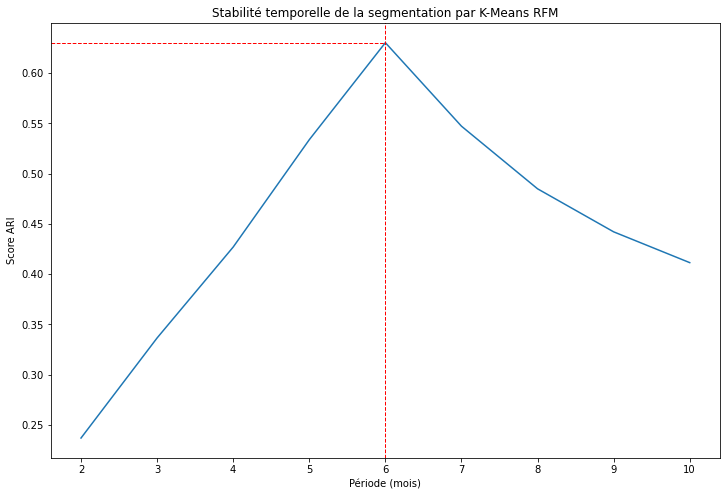

In [18]:
ari_score_RFM = pd.DataFrame(ari_score_RFM, columns=["periode", "ARI"])

fig = plt.figure(figsize=(12, 8))
sns.lineplot(data=ari_score_RFM, x="periode", y="ARI")


plt.axhline(y=ari_score_RFM.iloc[4][1], linestyle="--",
            color="r",
            xmax=0.5,
            linewidth=1)

plt.axvline(x=ari_score_RFM.iloc[4][0], linestyle="--",
            color="r",
            ymax=2-(ari_score_RFM.iloc[4][1]),
            linewidth=1)


plt.xlabel("Période (mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means RFM")
plt.show()

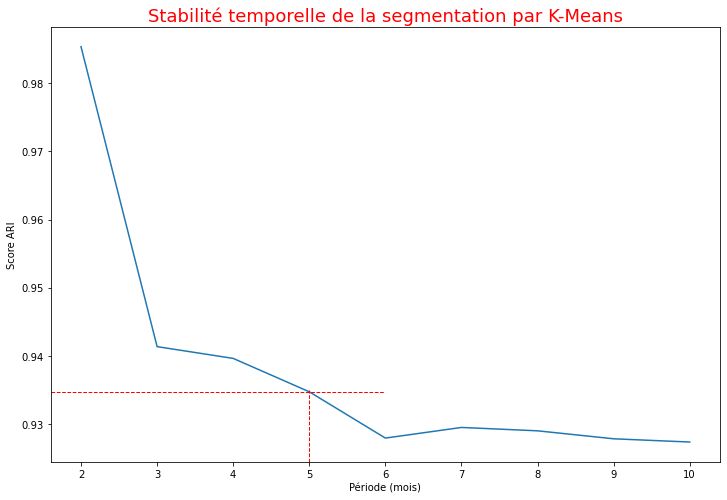

In [17]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

fig = plt.figure(figsize=(12, 8))
sns.lineplot(data=ari_score, x="periode", y="ARI")
plt.axhline(y=ari_score.iloc[3][1], linestyle="--",
            color="r",
            xmax=0.5,
            linewidth=1)
plt.axvline(x=ari_score.iloc[3][0], linestyle="--",
            color="r",
            ymax=1.1-(ari_score.iloc[3][1]),
            linewidth=1)
plt.xlabel("Période (mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="r")
plt.show()